In [3]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.chdir("/content/drive/My Drive/UNSA/8 semestre/Proyecto fin de carrera/REPOSITORIO/")
#!cp '/content/drive/My Drive/UNSA/8 semestre/Proyecto fin de carrera/REPOSITORIO/unetpconv2d.py' ./
from unetpconv2d import PConvUNET
#!cp '/content/drive/My Drive/UNSA/8 semestre/Proyecto fin de carrera/REPOSITORIO/image_maskgenerator.py' ./
from image_maskgenerator import MaskGenerator
#!cp '/content/drive/My Drive/UNSA/8 semestre/Proyecto fin de carrera/REPOSITORIO/pytorch_to_keras_vgg16.h5' ./

In [5]:
#!cp '/content/drive/My Drive/UNSA/8 semestre/Proyecto fin de carrera/REPOSITORIO/requirements.txt' ./
!pip install -r requirements.txt 

In [6]:
#!mv '/content/drive/My Drive/UNSA/8 semestre/Proyecto fin de carrera/REPOSITORIO/DL#+Beginner.zip' '/'

In [7]:
#!wget https://s3-ap-southeast-1.amazonaws.com/he-public-data/DL%23+Beginner.zip

In [8]:
#!7z e DL#+Beginner.zip
#!7z x train.zip
#!7z x test.zip

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import glob
import numpy as np
path = np.array(glob.glob('train/*.jpg'))
p = glob.glob('train/*.jpg')
#test_path = glob.glob('test/*.jpg')

In [27]:
from sklearn.model_selection import train_test_split
train,val,_,_ = train_test_split(path,path,test_size=0.2)
print(len(val))
print(len(train))

2600
10400


# Image Data Generator

In [11]:
from keras.utils import Sequence
import math
import numpy as np
import copy

class Data_Generator(Sequence):
    
    def __init__(self,x_path,batch_size=4,mode='train'):
        
        self.path = x_path
        self.batch_size = batch_size
        self.size=len(x_path)
        self.mode = mode
        
    def __getitem__(self,idx):
        
        start = idx*self.batch_size
        end = min((idx+1)*self.batch_size, self.size)
        
        x=[]
        mask=[]
        y=[]
        
        for i in range(start,end):
            im = cv2.imread(str(self.path[i]))
            im = cv2.resize(im,(512,512))
            im = im/255
            #print(im.dtype)
            
            
            m=MaskGenerator(im,0.02)
            #m.masker()
            M = m.mask
            #print(M.dtype)
            
            if self.mode == 'train' :
                #random-crop
                p,q = np.random.randint(0,256,2)
                im1 = cv2.resize(im[p:p+256,q:q+256],(512,512))
                mask1 = cv2.resize(M[p:p+256,q:q+256],(512,512))
                mask.append(mask1)
                y.append(im1)
                im1 = copy.deepcopy(im1)
                im1[mask1==0] = 1
                x.append(im1)
                            
                #zooming
                zoom_factor = 2
                rows = 512
                cols = 512
                u = int(rows/(zoom_factor*2))
                v = int(cols/(zoom_factor*2))
                i = im[rows//2-u:rows//2+u,cols//2-v:cols//2+v]
                mask2 = M[rows//2-u:rows//2+u,cols//2-v:cols//2+v]
                mask2 = cv2.resize(mask2,(512,512))
                zoom_i = cv2.resize( i ,(512,512))
                mask.append(mask2)
                y.append(zoom_i)
                zoom_i = copy.deepcopy(zoom_i)
                zoom_i[mask2==0] = 1
                x.append(zoom_i)
                #plt.imshow(im)
    
                
                #Horizontal flipping
                img3 = np.fliplr(im)
                mask3 = np.fliplr(M)
                y.append(img3)
                mask.append(mask3)
                img3 = copy.deepcopy(img3)
                img3[mask3==0] = 1
                x.append(img3)
                #plt.imshow(im)
                
                #Random-rotation
                degrees = np.random.randint(0,45)
                r = cv2.getRotationMatrix2D((cols/2,rows/2),degrees,1)
                img4  = cv2.warpAffine(im,r,(cols,rows))
                mask4 = cv2.warpAffine(M,r,(cols,rows))
                img4 = cv2.resize( img4 ,(512,512))
                mask4 = cv2.resize(mask4 ,(512,512))
                #plt.imshow(img4)
                y.append(img4)
                mask.append(mask4)
                img4 = copy.deepcopy(img4)
                img4[mask4==0]=1
                x.append(img4)

            
            
            y.append(im)
            im = copy.deepcopy(im)
            im[M==0] = 1
            mask.append(M)
            x.append(im)
            
        x    = np.array(x)
        mask = np.array(mask)
        y    = np.array(y)
        return [x,mask],y 
            
    
    def __len__(self):
        return math.ceil(self.size / self.batch_size)
    

An instance of the Image Data Generatot to use during training :-

In [12]:
from image_maskgenerator import MaskGenerator
from unetpconv2d import PConvUNET
traingen = Data_Generator(train,1)
valgen   = Data_Generator(val,2,'val')
x,y = traingen.__getitem__(1)

In [13]:
y.shape

(5, 512, 512, 3)

#Visualising a few examples :-

---



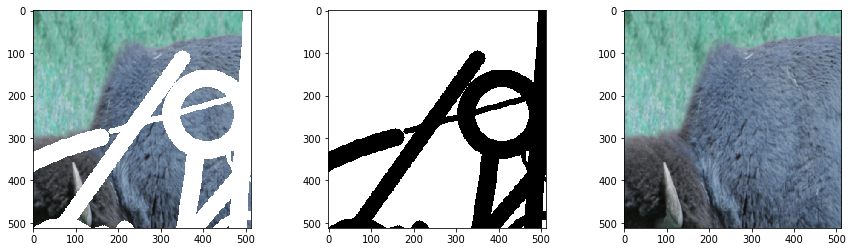

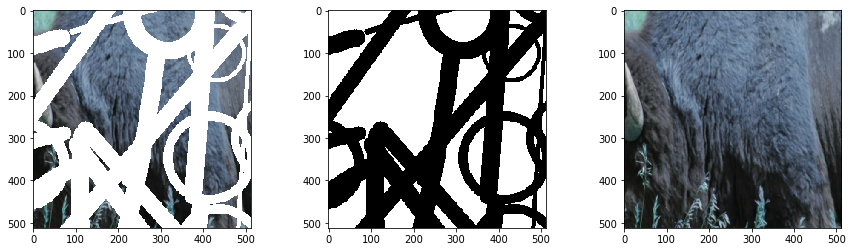

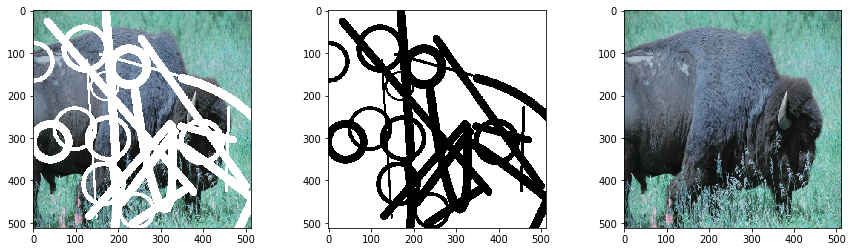

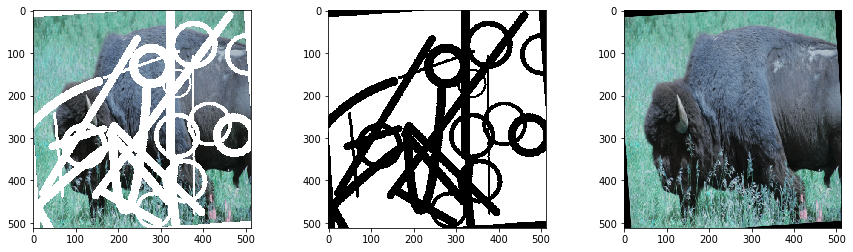

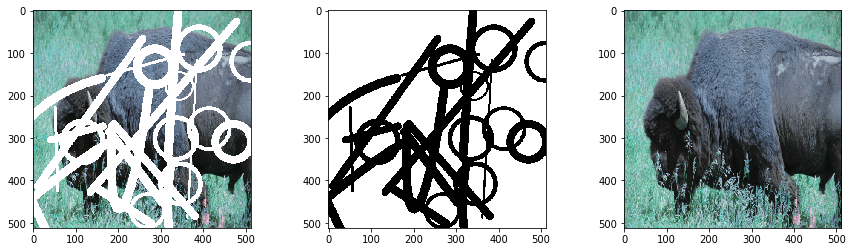

In [14]:
for i in range(5):
    _, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].imshow(x[0][i])
    axes[1].imshow(x[1][i]*1.)
    axes[2].imshow(y[i,:,:,:])
    plt.show()
    

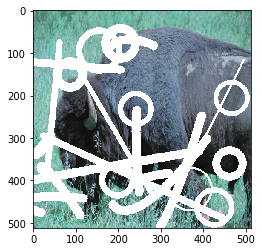

In [15]:
gen = Data_Generator(np.array([train[1]]),1)
x,y = gen.__getitem__(0)
plt.imshow(x[0][4])

# Creating a U-NET model by using the PConvUNET class

In [16]:
img_rows    = 512
img_columns = 512
channels    = 3

model = PConvUNET(img_rows,
                  img_columns,
                  channels,
                  weights='pytorch_to_keras_vgg16.h5')

model.model,model.masks=model.build_pconv_UNet(train_bn=False)
model.model_compile(model.model,model.masks,lr=1e-5)


Loading weights

In [17]:
#!cp gdrive/'My Drive'/Best-weights-my_model-003-3.7744-15.6183.hdf5 ./
#model.model.load_weights('Best-weights-my_model-003-3.7744-15.6183.hdf5')
#/content/gdrive/My Drive/Best-weights-my_model-001-5.4188-14.4929.hdf5

**Callbacks :-** 

In [25]:
from keras import callbacks
import math

filename='model_train_new.csv'
csv_log=callbacks.CSVLogger(filename, separator=',', append=False)

early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                                       patience=10, verbose=1, mode='min',
                                       restore_best_weights=True)

filepath="/content/drive/My Drive/UNSA/8 semestre/Proyecto fin de carrera/REPOSITORIO/checkpoints/weights-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1,
                                       save_best_only=True, mode='min')

def step_decay(epoch):
	initial_lrate = 5e-5
	drop = 0.5
	epochs_drop = 10.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

lrs = callbacks.LearningRateScheduler(step_decay, verbose=1)

callbacks_list = [csv_log,early_stopping,checkpoint]


In [19]:
masked_img = x[0][4]
mask       = x[1][4]
#generator  = Data_Generator(np.asarray(['cat.jpeg']),1)
#x,y = generator.__getitem__(0)
y.shape
mask.shape

(512, 512, 3)

In [20]:
def plot_sample_data(a,b,c):
    _, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].imshow(a)
    axes[1].imshow(b*1.)
    axes[2].imshow(c)
    plt.show()

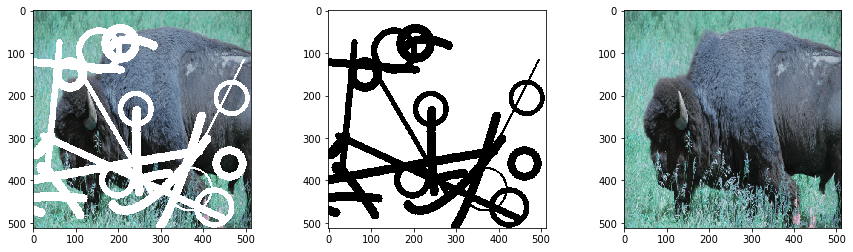

In [21]:
plot_sample_data(masked_img,mask,y[4])

In [22]:
from keras.preprocessing.image import ImageDataGenerator
class DataGenerator(ImageDataGenerator):
    def flow(self, x, *args, **kwargs):
        while True:
            
            # Get augmentend image samples
            ori = next(super().flow(x, *args, **kwargs))
            #print(type(ori),ori.shape)
            # Get masks for each image sample
            mask = np.stack([MaskGenerator(ori[0],0.02).mask for _ in range(ori.shape[0])], axis=0 )

            
            masked = copy.deepcopy(ori)
            masked[mask==0] = 1
            
            plo
            yield [masked,mask], ori       

# Create datagen
datagen = DataGenerator(  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Create generator from numpy array
generator = datagen.flow(x=traingen.__getitem__(np.random.randint(0,2500)), batch_size=4)

In [24]:
model.generator(
    traingen, 
    steps_per_epoch=2,
    epochs=1,
    callbacks=[
        callbacks.TensorBoard(
            log_dir='./data/logs/single_image_test',
            write_graph=True
        ),
        callbacks.ModelCheckpoint(
            './checkpoints/weights-{epoch:03d}-{loss:.4f}-{PSNR:.4f}.hdf5',
            monitor='loss', 
            save_best_only=True, 
            save_weights_only=True
        ),
        callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_sample_data(
                masked_img, 
                model.predict(
                    [
                        np.expand_dims(masked_img,0),np.expand_dims(mask,0)
                    ]
                )[0]    
                , 
                y[4]
            )
            
        )
    ],
    validation_data = valgen
)

Epoch 1/1
4/5 [=======================>......] - ETA: 1:01 - loss: 35.1126 - PSNR: 6.0913

KeyboardInterrupt: ignored

In [2]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))



This error most likely means that this notebook is not configured to use a GPU.  Change this in Notebook Settings via the command palette (cmd/ctrl-shift-P) or the Edit menu.




SystemError: ignored

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

AttributeError: ignored

In [4]:
tf.test.gpu_device_name()

''